In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import numpy as np
from tqdm.auto import tqdm

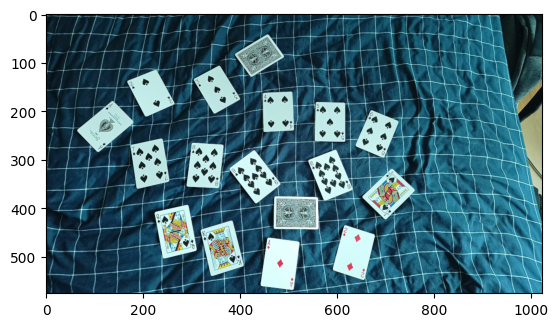

In [2]:
img = cv.imread("../assets/sample/cardset1.jpg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)

  0%|          | 0/50 [00:00<?, ?it/s]

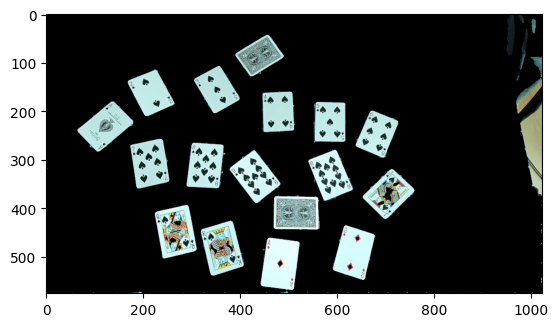

In [4]:
kimg = cv.cvtColor(img, cv.COLOR_RGB2HSV)[:, :, :2]
imgEdge = np.sum(np.abs(np.gradient(cv.cvtColor(img, cv.COLOR_RGB2GRAY))), axis=0)/255
# levelSet = np.random.uniform(-1, 1, img.shape[:-1])
levelSet = np.zeros(img.shape[:-1]) + 0.00001
for i in range(0, levelSet.shape[0], 100):
    for j in range(0, levelSet.shape[1], 100):
        levelSet[i:i+50,j:j+50] = -0.00001

for i in tqdm(range(50)):
    bgMean = kimg[levelSet>0].mean(axis=0)
    fgMean = kimg[levelSet<0].mean(axis=0)
    
    if fgMean[1] > bgMean[1]:
        bgMean, fgMean = fgMean, bgMean
    
    levelGradY, levelGradX = np.gradient(levelSet)
    gradNorm = np.sqrt(np.square(levelGradX) + np.square(levelGradY))
    levelGradY /= (gradNorm + 0.00001)
    levelGradX /= (gradNorm + 0.00001)
    colorGrad = -np.sqrt(np.sum(np.power(np.abs(kimg - bgMean), 2), axis=2))/255 + np.sqrt(np.sum(np.power(np.abs(kimg - fgMean), 2), axis=2))/255
    
    levelSet += 1.0 * (1-imgEdge) * np.abs(levelGradX) * colorGrad
    levelSet += 1.0 * (1-imgEdge) *np.abs(levelGradY) * colorGrad
    levelDiv = (levelSet[:-2, 1:-1] + levelSet[2:, 1:-1] + levelSet[1:-1, :-2] + levelSet[1:-1, 2:] - 4*levelSet[1:-1, 1:-1])/4
    levelSet += 1.0*np.pad(levelDiv, 1)
plt.figure()
plt.imshow(img * np.expand_dims(levelSet < 0, 2))

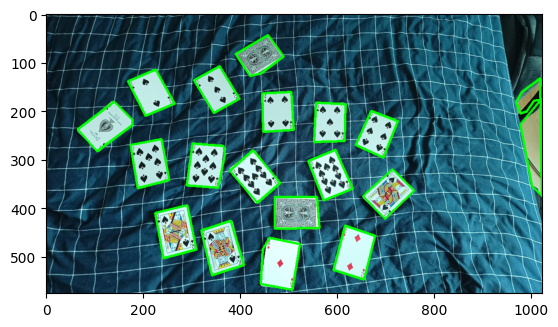

In [5]:
mask = levelSet < 0
contours, _ = cv.findContours(mask.astype('uint8'), cv.RETR_EXTERNAL , cv.CHAIN_APPROX_SIMPLE)
valid_contours = [cv.approxPolyDP(c, 5, True) for c in contours if cv.contourArea(c) > 3000]
cimg = img.copy()
cv.drawContours(cimg, valid_contours, -1, (0,255,0), 3)
plt.imshow(cimg)

0.9343544857768052

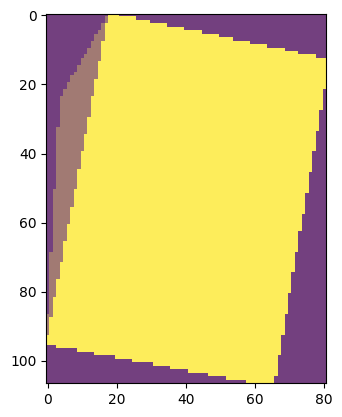

In [67]:
def quad(contour):
    minx, maxx = contour[:, :, 0].min(), contour[:, :, 0].max()
    miny, maxy = contour[:, :, 1].min(), contour[:, :, 1].max()
    
    basemask = np.zeros((maxy-miny, maxx-minx), dtype='uint8')
    cv.fillConvexPoly(basemask, contour - np.array([[minx, miny]]), 1)
    
    bestHull = None
    bestHullIoU = 0
    for i in range(10):
        c = np.random.choice(np.arange(len(contour)), 4, replace=False)
        hull = cv.convexHull(contour[c])
        
        simmask = np.zeros_like(basemask)
        cv.fillConvexPoly(simmask, hull - np.array([[minx, miny]]), 1)
        iou = (simmask & basemask).sum()/(simmask | basemask).sum()
        if  iou > bestHullIoU:
            bestHullIoU = iou
            bestHull = hull            
    return bestHull, bestHullIoU

def drawHull(contour, alpha):
    minx, maxx = contour[:, :, 0].min(), contour[:, :, 0].max()
    miny, maxy = contour[:, :, 1].min(), contour[:, :, 1].max()
    basemask = np.zeros((maxy-miny, maxx-minx), dtype='uint8')
    cv.fillConvexPoly(basemask, contour - np.array([[minx, miny]]), 1)
    plt.imshow(basemask, alpha=alpha)

drawHull(valid_contours[0], 0.5)
drawHull(quad(valid_contours[0])[0], 0.5)
quad(valid_contours[0])[1]

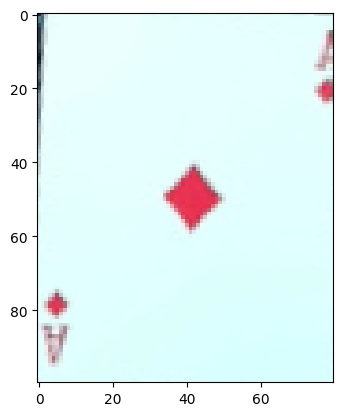

In [123]:
def cardProject(img, quad):
    dst = np.array([
        [0, 0],
        [0, 100],
        [80, 100],
        [80, 0],
    ], dtype='float32')
    if np.sqrt(((quad[0, 0, :] - quad[1, 0, :])**2).sum()) < np.sqrt(((quad[1, 0, :] - quad[2, 0, :])**2).sum()) :
        quad = np.concatenate([quad[1:], quad[0:1]])
    mtx = cv.getPerspectiveTransform(quad.astype('float32'), dst)
    timg= cv.warpPerspective(img, mtx, (80, 100))
    return timg
plt.imshow(cardProject(img, quad(valid_contours[0])[0]))

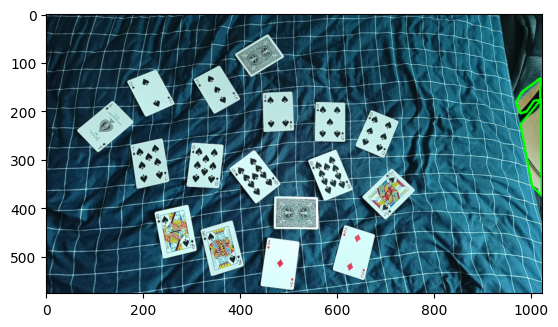

In [122]:
cimg = img.copy()
cv.drawContours(cimg, valid_contours, 14, (0,255,0), 3)
plt.imshow(cimg)

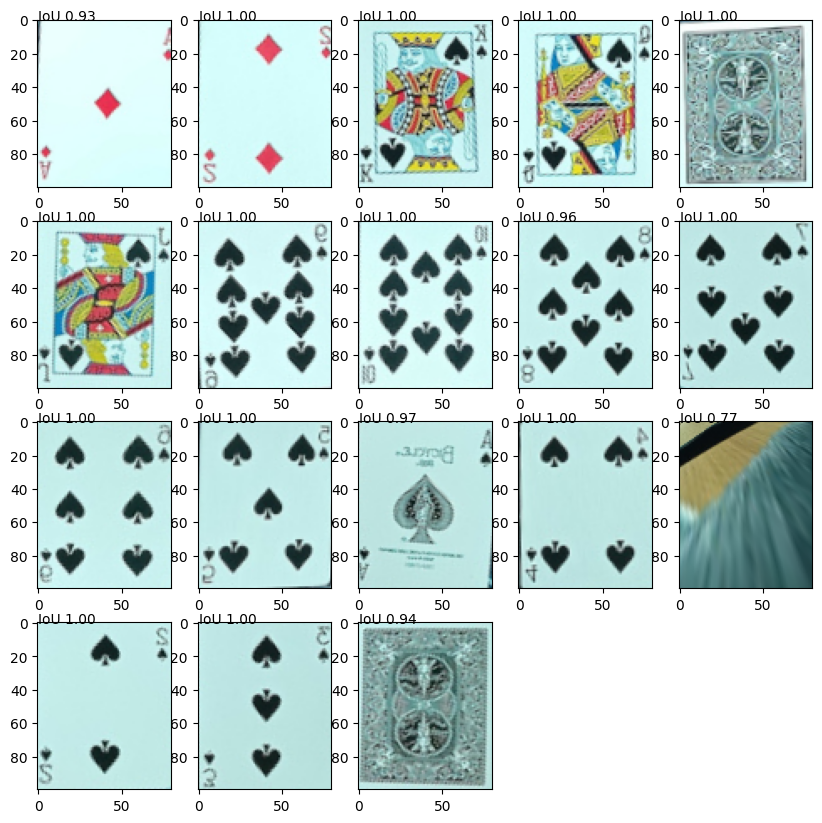

In [137]:
plt.figure(figsize=(10, 10))
for i, c in enumerate(valid_contours):
    plt.subplot(4, (len(valid_contours)  +3)//4, i + 1)
    q, iou = quad(c)
    out = cardProject(img, q)
    plt.imshow(out)
    plt.text(0, 0, f"IoU {iou:.2f}")